<a href="https://colab.research.google.com/github/tjfgns6043/ML-Class/blob/main/2%EC%9E%A5_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import os
import tarfile
import urllib

In [35]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

fetch_housing_data()

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

#housing을 학번으로 변경
housing_175091 = load_housing_data()

#head() method를 사용하여 데이터 특성 확인
housing_175091.head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


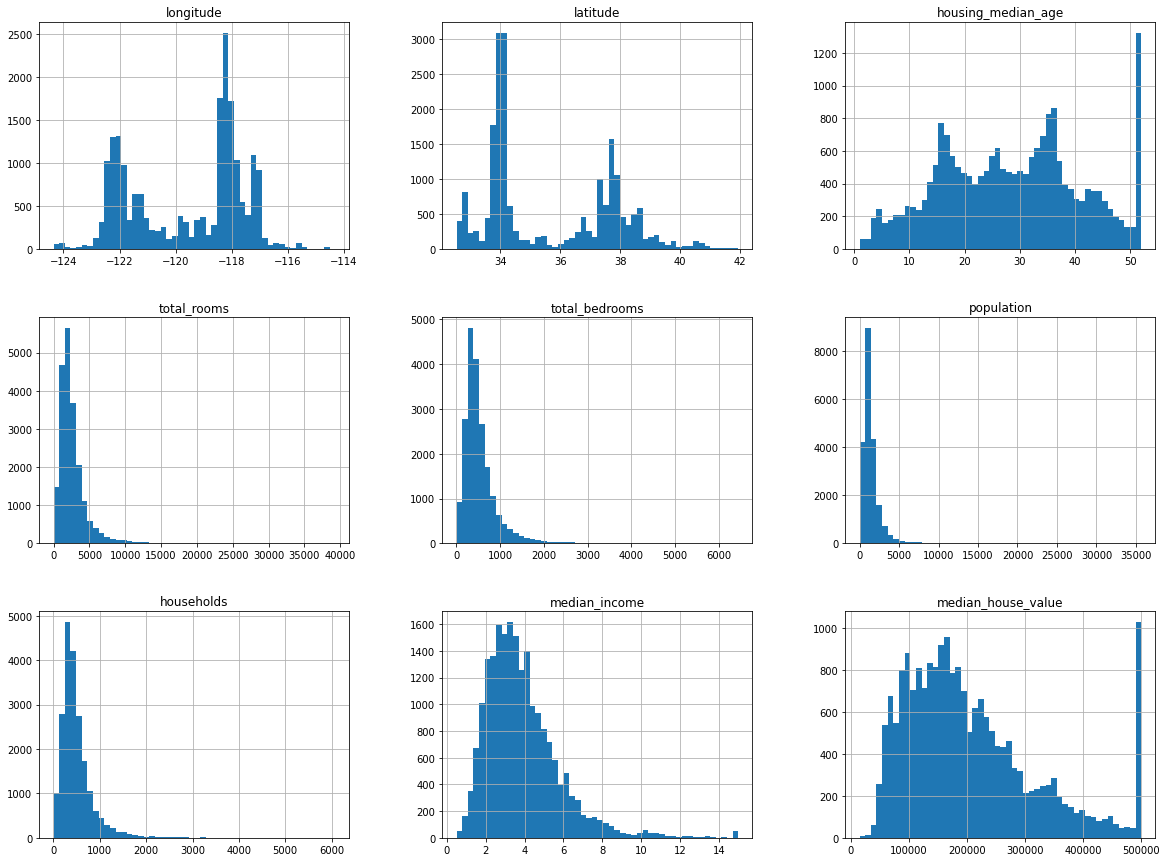

In [36]:
#Hist 함수 사용하여 각 컬럼의 데이터 분포 파악
import matplotlib.pyplot as plt
housing_175091.hist(bins=50, figsize=(20,15))
plt.show()

In [37]:
#데이터 구조 자세히 알아보기
housing_175091.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [38]:
#사이킷런을 이용해 테스트 세트 만들기
from sklearn.model_selection import train_test_split

#전체의 20% 표본을 테스트 세트로 지정
train_set, test_set = train_test_split(housing_175091, test_size = 0.2 , random_state = 42)

test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


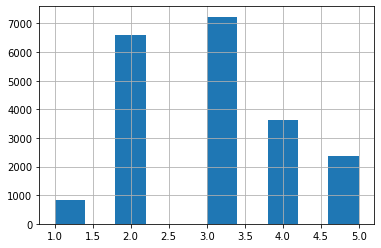

In [39]:
#전문가의 조언에 따라 중간 소득이 주택 가격 예측에 중요하다고 가정. 중간 소득이 연속적인 숫자형 특성이므로 소득에 대한 카테고리 특성 생성
import numpy as np
housing_175091["income_cat"] = pd.cut(housing_175091["median_income"],
                                      bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                      labels=[1,2,3,4,5])

housing_175091["income_cat"].hist()

In [40]:
#소득 카테고리 기반으로 계층 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits= 1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(housing_175091, housing_175091["income_cat"]):
  strat_train_set = housing_175091.loc[train_index]
  strat_test_set = housing_175091.loc[test_index]


#테스트 세트에서 소득 카테고리의 비율
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [41]:
#income_cat 특성 삭제하여 원상태로 복구
for set_ in(strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

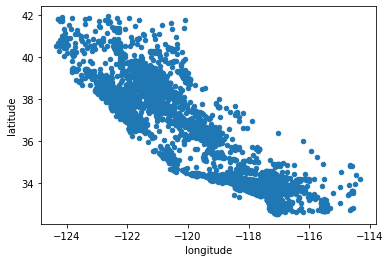

In [42]:
#데이터 이해를 위한 데이터 시각화 훈련 세트 전체를 사용 
housing_175091 = strat_train_set.copy()


#산점도
housing_175091.plot(kind = "scatter", x="longitude", y="latitude")

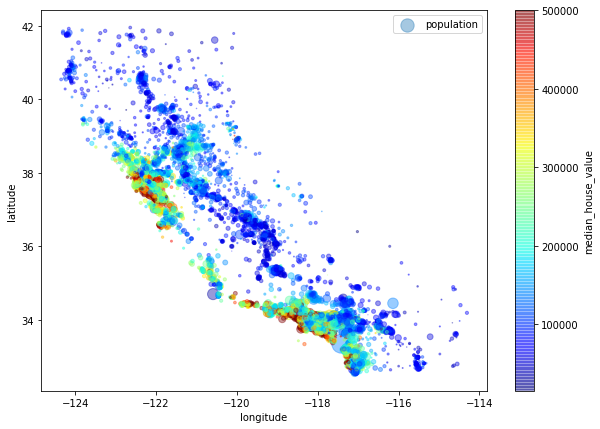

In [43]:
#주택 가격 : 원의 반지름 - 구역의 인구(매개변수 s), 색상은 가격(매개변수 c).
housing_175091.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                    s=housing_175091["population"]/100, label="population", figsize=(10,7),
                    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
                    sharex=False
                    )

plt.legend()

In [44]:
#데이터 상관관계 출력하기

#corr() 메서드를 이용해 표준 상관계수 계산
#-1에 가까울수록 관계가 깊으며 0에 가까울 수록 관계가 적다

corr_matrix = housing_175091.corr()
corr_matrix


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [45]:
#머신러닝 알고리즘을 위한 데이터 준비
#원래 훈련 세트로 복원하고 예측 변수와 타깃값에 같은 변형을 적용하지 않기 위해 예측 변수와 레이블 분리

housing_175091 = strat_train_set.drop("median_house_value", axis=1)
housing_175091_labels = strat_train_set["median_house_value"].copy()


In [46]:
#책에 소개된 옵션 설명위해 데이터셋 복사본 만듬. 적어도 하나의 열이 비어있는 행을 골라서 옵션의 정확한 동작을 눈으로 확인
sample_incomplete_rows = housing_175091[housing_175091.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [47]:
# total_bedrooms 특성의 null 값 수정 dropna
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [48]:
# total_bedrooms 특성의 null 값 수정 drop
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [49]:
# total_bedrooms 특성의 null 값 수정 fillna
median = housing_175091["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [50]:
#누락값을 손쉽게 다루도록 해주는 사이킷런의 SimpleImputer 사용 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [51]:
#텍스트 특성인 ocean_proximity를 제외하기
housing_175091_num = housing_175091.drop("ocean_proximity", axis=1)
imputer.fit(housing_175091_num)

imputer.statistics_


array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [52]:
#학습된 imputer 객체를 사용해 훈련 세트에서 누락된 값을 학습한 중간값으로 바꿈
X = imputer.transform(housing_175091_num)
housing_175091_tr = pd.DataFrame(X, columns=housing_175091_num.columns,
                                 index=housing_175091_num.index)

housing_175091_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [53]:
#범주형 특성 다루기
housing_175091_cat = housing_175091[["ocean_proximity"]]
housing_175091_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [54]:
#카테고리를 텍스트에서 숫자로 변환하기 위해 사이킷런의 OrdinalEncoder 클래스 사용

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_175091_cat_encoded = ordinal_encoder.fit_transform(housing_175091_cat)
housing_175091_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [55]:
#OrdinalEncoder 방식의 문제점 : 가까이 있는 두 값이 떨어져 있는 두 값보다 더 비슷하다고 생각. 하지만 ocean_proximity열에 해당되지 않는다 그래서 이진 특성을 만드는 원-핫 인코딩 사용

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_175091_cat_1hot = cat_encoder.fit_transform(housing_175091_cat)
housing_175091_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
#파이프라인 만들기 위한 사용자 정의 변환기

In [57]:
#파이프라인 설계하기
#숫자 특성을 처리하는 간단한 파이프라인

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('srd_scaler', StandardScaler()),
])

housing_175091_num_tr = num_pipeline.fit_transform(housing_175091_num)

In [58]:
housing_175091_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

In [60]:
#하나의 변환기로 각 열마다 적절한 변환을 적용하여 모든 열을 처리하기 위해 사이킷런의 ColumnTransformer 사용
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_175091_num) #수치형 열 이름의 리스트
cat_attribs = ["ocean_proximity"] #범주형 열 이름의 리스트

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ]) #원-핫 인코더는 희소행렬을 반환하지만 num_pipeline는 밀집 행렬을 반환

housing_175091_prepared = full_pipeline.fit_transform(housing_175091)

In [61]:
housing_175091_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [62]:
#선형회귀 모델 훈련
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_175091_prepared, housing_175091_labels)

LinearRegression()

In [63]:
#훈련 세트에 있는 몇 개 샘플에 대해 적용
some_data = housing_175091.iloc[:5]
some_labels = housing_175091_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102
 246840.18988841]


In [64]:
#실제값
print("레이블:", list(some_labels))

레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [67]:
#결정트리 사용
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_175091_prepared, housing_175091_labels)

DecisionTreeRegressor(random_state=42)

In [68]:
housing_175091_predictions = tree_reg.predict(housing_175091_prepared)
tree_mse = mean_squared_error(housing_175091_labels, housing_175091_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [69]:
#랜덤포레스트 사용
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_175091_prepared, housing_175091_labels)

housing_175091_predictions = forest_reg.predict(housing_175091_prepared)
forest_mse = mean_squared_error(housing_175091_labels, housing_175091_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18414.656140126073

In [71]:
#교차검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_175091_prepared, housing_175091_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [72]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

#결정 트리의 결과 성능
display_scores(tree_rmse_scores)

점수: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
평균: 69081.361562518
표준 편차: 2296.288087393378


In [73]:
#선형 회귀 모델의 결과 성능
lin_scores = cross_val_score(lin_reg, housing_175091_prepared, housing_175091_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
평균: 69204.32275494764
표준 편차: 2372.070791055919


In [74]:
#랜덤 포레스트 결과 성능
forest_scores = cross_val_score(forest_reg, housing_175091_prepared, housing_175091_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [50751.36502244 49002.1539723  45845.4322613  50547.8348981
 47029.50227939 49443.32220562 51741.36634632 48796.68210779
 47564.35711488 53108.92619962]
평균: 49383.09424077689
표준 편차: 2110.1405417770225


In [75]:
#그리드 서치 -> GridSearchCV를 사용하여 가능한 모든 하이퍼 파라미터 조합에 대해 교차 검증을 사용하여 평가
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_175091_prepared, housing_175091_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [76]:
#최적의 조합
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [77]:
#랜덤 서치 -> 그리드 탑색은 비교적 적은 수의 조합을 탐구할 때 좋음. 하이퍼파라미터 탐색 공간이 커지면 랜덤탐색이 효율적
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_175091_prepared, housing_175091_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb8cad90750>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb8cad90e10>},
                   random_state=42, scoring='neg_mean_squared_error')

In [78]:
#최적의 조합
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49121.49837525519 {'max_features': 7, 'n_estimators': 180}
51272.09460120037 {'max_features': 5, 'n_estimators': 15}
50535.37125677256 {'max_features': 3, 'n_estimators': 72}
50689.968708041284 {'max_features': 5, 'n_estimators': 21}
49129.57573326101 {'max_features': 7, 'n_estimators': 122}
50491.86588833997 {'max_features': 3, 'n_estimators': 75}
50414.569062947536 {'max_features': 3, 'n_estimators': 88}
49462.00096652969 {'max_features': 5, 'n_estimators': 100}
50200.230149209325 {'max_features': 3, 'n_estimators': 150}
64800.37553997819 {'max_features': 5, 'n_estimators': 2}


In [79]:
#테스트 세트로 시스템 평가
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test) #fit 사용하면 x 테스트 세트에서 훈련하면 안되므로
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)


final_rmse

47859.544319108194

In [80]:
#이 추정값이 얼마나 정확한지 알기위해 일반화 오차의 95% 신뢰구간 계산
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45909.04350565, 49733.6072416 ])